In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from linearmodels.panel import PanelOLS, compare 
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


## Bases de dados

In [30]:
df_empreend = pd.read_csv('../dados/tratados/simu_carteira_empreendimentos.csv')
df_agrup_munic_ano = pd.read_csv('../dados/tratados/agrupamento_empreend_acidentes_por_municipio_e_ano_sem_nulos.csv')

In [31]:
print(df_agrup_munic_ano.columns.tolist())
df_agrup_munic_ano.head()

['Código IBGE', 'ano', 'vlr_investimento', 'pop_beneficiada', 'num_total_empreendimentos', 'aux_emp_implantacao', 'aux_emp_implantacao_vlr_investimento', 'aux_emp_pavimentacao', 'aux_emp_pavimentacao_vlr_investimento', 'aux_emp_refrota', 'aux_emp_refrota_vlr_investimento', 'aux_emp_sinalizacao', 'aux_emp_sinalizacao_vlr_investimento', 'aux_emp_calcamento', 'aux_emp_calcamento_vlr_investimento', 'aux_emp_ciclovia', 'aux_emp_ciclovia_vlr_investimento', 'aux_emp_corredor', 'aux_emp_corredor_vlr_investimento', 'aux_emp_drenagem', 'aux_emp_drenagem_vlr_investimento', 'aux_emp_ferrovia', 'aux_emp_ferrovia_vlr_investimento', 'aux_emp_transporte', 'aux_emp_transporte_vlr_investimento', 'aux_emp_brt', 'aux_emp_brt_vlr_investimento', 'aux_emp_vlt', 'aux_emp_vlt_vlr_investimento', 'aux_emp_qualificacao', 'aux_emp_qualificacao_vlr_investimento', 'aux_emp_mobilidade_urbana', 'aux_emp_mobilidade_urbana_vlr_investimento', 'aux_emp_aquisicao', 'aux_emp_aquisicao_vlr_investimento', 'aux_emp_polongament

,Código IBGE,ano,vlr_investimento,pop_beneficiada,num_total_empreendimentos,aux_emp_implantacao,aux_emp_implantacao_vlr_investimento,aux_emp_pavimentacao,aux_emp_pavimentacao_vlr_investimento,aux_emp_refrota,...,taxa_mun_motociclista_feridos,taxa_mun_automovel_feridos,taxa_mun_veiculo_pesado_feridos,taxa_mun_onibus_feridos,taxa_mun_outros_feridos,Populacao,taxa_mun_triciclo_mortes,taxa_mun_caminhonete_mortes,taxa_mun_triciclo_feridos,taxa_mun_caminhonete_feridos
0,1100015.0,2011.0,1530000.00,1841.0,2,0,0.0,2,1530000.00,0,...,0.000000,0.000000,0.0,0.000000,0.000000,24228.0,0.0,0.0,0.0,0.0
1,1100023.0,2012.0,1787781.82,2087.0,2,0,0.0,0,0.00,0,...,0.177903,0.002156,0.0,0.000000,0.000000,92747.0,0.0,0.0,0.0,0.0
2,1100023.0,2014.0,36842105.26,43512.0,1,0,0.0,1,36842105.26,0,...,0.055415,0.000000,0.0,0.000972,0.000000,102860.0,0.0,0.0,0.0,0.0
3,1100031.0,2011.0,265850.00,306.0,1,0,0.0,1,265850.00,0,...,0.000000,0.000000,0.0,0.000000,0.000000,6221.0,0.0,0.0,0.0,0.0
4,1100049.0,2010.0,2821324.40,3343.0,3,0,0.0,2,2290724.40,0,...,0.006363,0.000000,0.0,0.000000,0.001273,78574.0,0.0,0.0,0.0,0.0


## 

## Seleciona variáveis para os dados em painel

**Eixos:**

eixo transversal = $Município$

eixo temporal = $ano$

**Variáveis dependentes:**

$y_1=total\_mortes$

$y_2=total\_feridos$

**Variáveis independentes:**

$X = Populacao, Populacao\_Beneficiada, Investimento\_pavimentacao, Investimento\_calcamento, Investimento\_ciclovia, Investimento\_ferrovia, Investimento\_BRT, Investimento\_VLT, Investimento\_Faixa\_Exclusiva$

Variáveis explicativas escolhidas, a princípio,  de forma arbitrária:

In [32]:
x_columns_numeric = [ 
    'Populacao', 'pop_beneficiada_per_capita', 
    'aux_emp_pavimentacao_vlr_investimento','aux_emp_calcamento_vlr_investimento', 'aux_emp_ciclovia_vlr_investimento', 'aux_emp_ferrovia_vlr_investimento','aux_emp_brt_vlr_investimento','aux_emp_vlt_vlr_investimento','aux_emp_faixa_exclusiva_vlr_investimento'
]

df_panel = df_agrup_munic_ano[['Código IBGE','ano', 'total_mortes', 'total_feridos', *x_columns_numeric]].copy()

df_panel[x_columns_numeric] = df_panel[x_columns_numeric]
df_panel['Código IBGE'] = df_panel['Código IBGE'].astype('category')
df_panel.set_index(['Código IBGE', 'ano'], inplace=True)
df_panel

total_mortes  total_feridos  Populacao  \
Código IBGE ano                                              
1100015.0   2011.0           0.0            0.0    24228.0   
1100023.0   2012.0          46.0          177.0    92747.0   
            2014.0          28.0           58.0   102860.0   
1100031.0   2011.0           0.0            0.0     6221.0   
1100049.0   2010.0          26.0           57.0    78574.0   
...                          ...            ...        ...   
5300108.0   2015.0         469.0         2906.0  2914830.0   
            2016.0         464.0         2894.0  2977216.0   
            2017.0         339.0         2416.0  3039444.0   
            2018.0         339.0         2619.0  2974703.0   
            2019.0         338.0         2635.0  3015268.0   

                    pop_beneficiada_per_capita  \
Código IBGE ano                                  
1100015.0   2011.0                    0.075986   
1100023.0   2012.0                    0.022502   
            2014.0                    0.423022   
1100031.0   2011.0                    0.049188   
1100049.0   2010.0                    0.042546   
...                                        ...   
5300108.0   2015.0                    0.007090   
            2016.0                    0.001235   
            2017.0                    0.001847   
            2018.0                    0.017045   
            2019.0                    0.000421   

                    aux_emp_pavimentacao_vlr_investimento  \
Código IBGE ano                                             
1100015.0   2011.0                             1530000.00   
1100023.0   2012.0                                   0.00   
            2014.0                            36842105.26   
1100031.0   2011.0                              265850.00   
1100049.0   2010.0                             2290724.40   
...                                                   ...   
5300108.0   2015.0                             2785984.00   
            2016.0                             2988382.00   
            2017.0                              988588.59   
            2018.0                             3725213.98   
            2019.0                             1020756.76   

                    aux_emp_calcamento_vlr_investimento  \
Código IBGE ano                                           
1100015.0   2011.0                                  0.0   
1100023.0   2012.0                                  0.0   
            2014.0                                  0.0   
1100031.0   2011.0                                  0.0   
1100049.0   2010.0                                  0.0   
...                                                 ...   
5300108.0   2015.0                                  0.0   
            2016.0                                  0.0   
            2017.0                                  0.0   
            2018.0                                  0.0   
            2019.0                                  0.0   

                    aux_emp_ciclovia_vlr_investimento  \
Código IBGE ano                                         
1100015.0   2011.0                               0.00   
1100023.0   2012.0                         1251042.30   
            2014.0                               0.00   
1100031.0   2011.0                               0.00   
1100049.0   2010.0                               0.00   
...                                               ...   
5300108.0   2015.0                               0.00   
            2016.0                               0.00   
            2017.0                          884006.08   
            2018.0                         1441471.26   
            2019.0                               0.00   

                    aux_emp_ferrovia_vlr_investimento  \
Código IBGE ano                                         
1100015.0   2011.0                                0.0   
1100023.0   2012.0                                0.0   
            2014.0            

## Efeitos Fixos

**Modelo simplificado**

$$y_{it} = \gamma_t + \beta'x_{it} + \epsilon_{it}$$

$$i = Município, \quad t = ano$$

https://bashtage.github.io/linearmodels/panel/panel/linearmodels.panel.model.PanelOLS.html


In [33]:
# Selecionar variáveis dependentes e independentes
X = df_panel[[*x_columns_numeric]]
y_mortes = df_panel['total_mortes'].astype(float)
y_feridos = df_panel['total_feridos'].astype(float)

# Adicionar constante
X = sm.add_constant(X).astype(float)

# Modelo de Efeitos Fixos para Mortes
fe_model_mortes = PanelOLS(y_mortes, X, entity_effects=True)
fe_model_mortes = fe_model_mortes.fit()
fe_model_mortes.summary

Dep. Variable:,total_mortes,R-squared:,0.5430
Estimator:,PanelOLS,R-squared (Between):,-62.623
No. Observations:,20700,R-squared (Within):,0.5430
Date:,"Sun, Jun 02 2024",R-squared (Overall):,-62.433
Time:,05:25:16,Log-likelihood,-7.564e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,2039.0
Entities:,5244,P-value,0.0000
Avg Obs:,3.9474,Distribution:,"F(9,15447)"
Min Obs:,1.0000,,
Max Obs:,10.0000,F-statistic (robust):,2039.0


In [34]:
# Modelo de Efeitos Fixos para Feridos
fe_model_feridos = PanelOLS(y_feridos, X, entity_effects=True)
fe_model_feridos = fe_model_feridos.fit()
fe_model_feridos.summary

Dep. Variable:,total_feridos,R-squared:,0.0771
Estimator:,PanelOLS,R-squared (Between):,-2.2645
No. Observations:,20700,R-squared (Within):,0.0771
Date:,"Sun, Jun 02 2024",R-squared (Overall):,-2.2634
Time:,05:25:16,Log-likelihood,-1.214e+05
Cov. Estimator:,Unadjusted,,
,,F-statistic:,143.36
Entities:,5244,P-value,0.0000
Avg Obs:,3.9474,Distribution:,"F(9,15447)"
Min Obs:,1.0000,,
Max Obs:,10.0000,F-statistic (robust):,143.36


### Resíduos

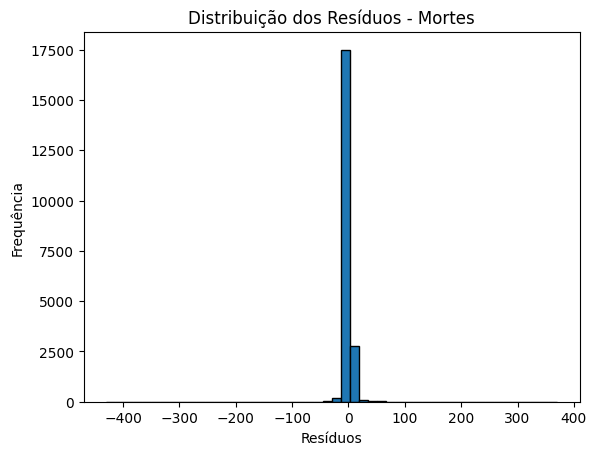

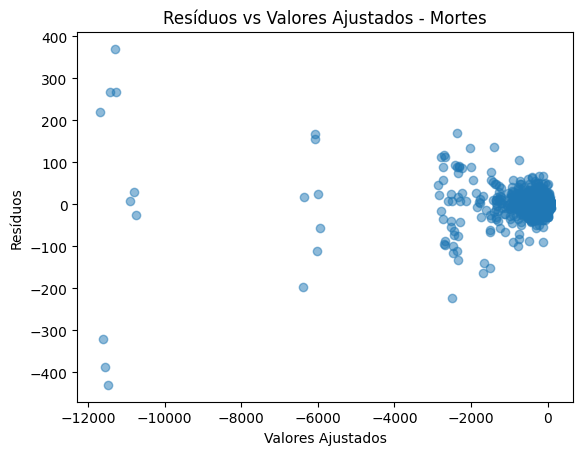

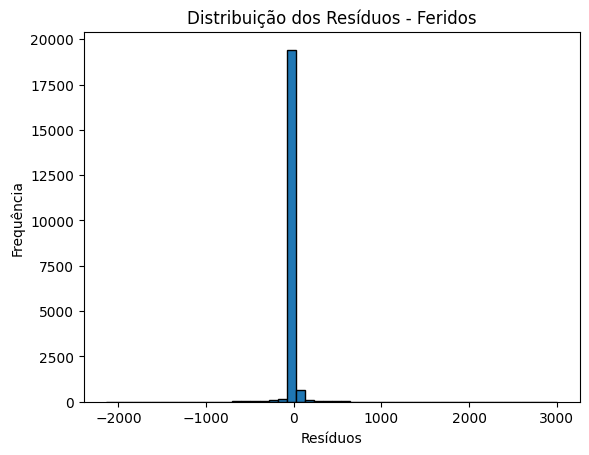

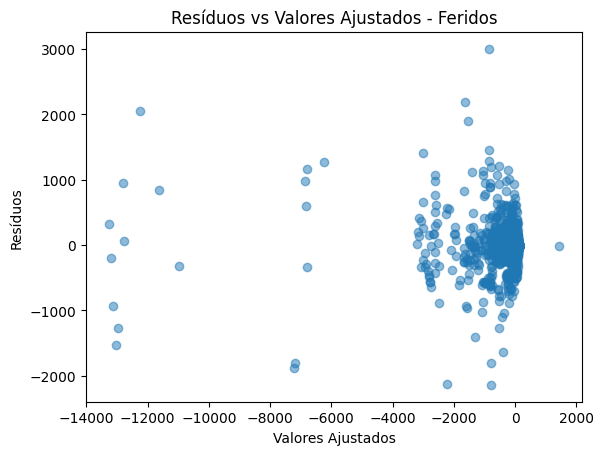

In [35]:

# Obter os resíduos do modelo de mortes
residuos_mortes = fe_model_mortes.resids

# Plotar um histograma dos resíduos
plt.hist(residuos_mortes, bins=50, edgecolor='k')
plt.title('Distribuição dos Resíduos - Mortes')
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.show()

# Plotar os resíduos vs valores ajustados
plt.scatter(fe_model_mortes.fitted_values, residuos_mortes, alpha=0.5)
plt.title('Resíduos vs Valores Ajustados - Mortes')
plt.xlabel('Valores Ajustados')
plt.ylabel('Resíduos')
plt.show()

# Repetir para os resíduos do modelo de feridos
residuos_feridos = fe_model_feridos.resids

# Plotar um histograma dos resíduos
plt.hist(residuos_feridos, bins=50, edgecolor='k')
plt.title('Distribuição dos Resíduos - Feridos')
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.show()

# Plotar os resíduos vs valores ajustados
plt.scatter(fe_model_feridos.fitted_values, residuos_feridos, alpha=0.5)
plt.title('Resíduos vs Valores Ajustados - Feridos')
plt.xlabel('Valores Ajustados')
plt.ylabel('Resíduos')
plt.show()


#### Teste de Breusch-Pagan para heteroscedasticidade

$H_0: Homoscedástico$

In [36]:
model_mortes = sm.OLS(y_mortes, X).fit()

# Realizando o teste de Breusch-Pagan para mortes
bp_test_mortes = het_breuschpagan(model_mortes.resid, model_mortes.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print("Breusch-Pagan Test for Total Mortes:")
print(dict(zip(labels, bp_test_mortes)))

# Ajustando o modelo com statsmodels para total de feridos
model_feridos = sm.OLS(y_feridos, X).fit()

# Realizando o teste de Breusch-Pagan para feridos
bp_test_feridos = het_breuschpagan(model_feridos.resid, model_feridos.model.exog)
print("Breusch-Pagan Test for Total Feridos:")
print(dict(zip(labels, bp_test_feridos)))

Breusch-Pagan Test for Total Mortes:
{'LM Statistic': 8111.807371651278, 'LM-Test p-value': 0.0, 'F-Statistic': 1481.3996247166026, 'F-Test p-value': 0.0}
Breusch-Pagan Test for Total Feridos:
{'LM Statistic': 3456.4045181974548, 'LM-Test p-value': 0.0, 'F-Statistic': 460.8023860670422, 'F-Test p-value': 0.0}


### Resíduos por efeito de munícipio ou ano 

In [37]:
df_aux_var = df_panel.copy()
residuos_mortes = fe_model_mortes.resids
df_aux_var = df_aux_var.merge(fe_model_mortes.resids, how='left', on=['Código IBGE', 'ano'], ).reset_index()
df_aux_var.rename(columns={'residual':'residuos_mortes'}, inplace=True)

# Agrupar e plotar resíduos médios por ano e municipio
residuos_por_ano = df_aux_var.groupby('ano')['residuos_mortes'].mean()
residuos_por_municipio = df_aux_var.groupby('Código IBGE')['residuos_mortes'].mean()

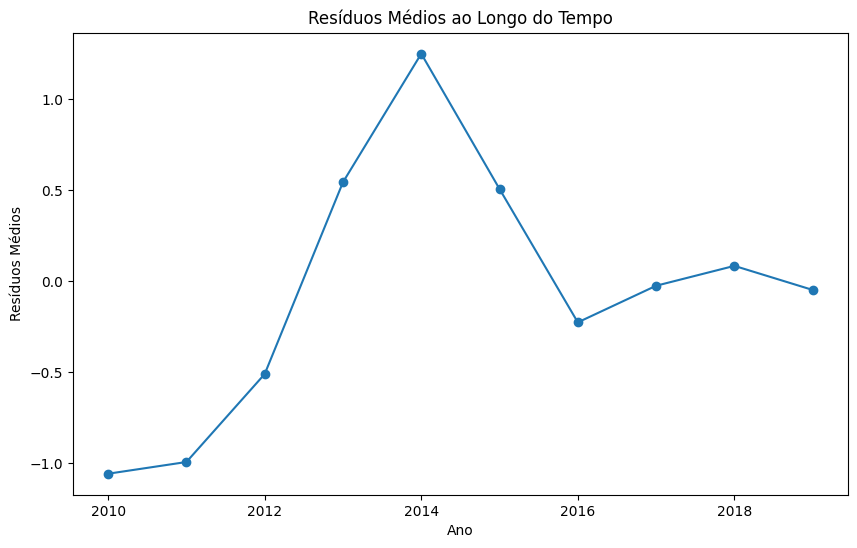

           LM p-value      F p-value
2011.0  2.099374e-170  3.924941e-255
2012.0  6.765776e-190   0.000000e+00
2014.0   0.000000e+00   0.000000e+00
2010.0   1.475738e-39   8.128167e-42
2013.0   0.000000e+00   0.000000e+00
2019.0   0.000000e+00   0.000000e+00
2015.0   0.000000e+00   0.000000e+00
2016.0   0.000000e+00   0.000000e+00
2017.0   0.000000e+00   0.000000e+00
2018.0   0.000000e+00   0.000000e+00


In [38]:
plt.figure(figsize=(10, 6))
plt.plot(residuos_por_ano, 'o-')
plt.title('Resíduos Médios ao Longo do Tempo')
plt.xlabel('Ano')
plt.ylabel('Resíduos Médios')
plt.show()

# Aplicar o teste de Breusch-Pagan para cada ano
bp_results_ano = {}
for year in df_aux_var['ano'].unique():
    df_year = df_aux_var[df_aux_var['ano'] == year]
    exog_year = df_year[x_columns_numeric]
    exog_year = sm.add_constant(exog_year)  # Adicionar constante
    _, lm_pvalue, _, f_pvalue = het_breuschpagan(df_year['residuos_mortes'], exog_year)
    bp_results_ano[year] = {'LM p-value': lm_pvalue, 'F p-value': f_pvalue}

bp_results_ano_df = pd.DataFrame(bp_results_ano).T
print(bp_results_ano_df)

In [39]:
# Aplicar o teste de Breusch-Pagan para cada município
bp_results_municipio = {}
for municipio in df_aux_var['Código IBGE'].unique():
    df_municipio = df_aux_var[df_aux_var['Código IBGE'] == municipio]
    if len(df_municipio) > 1:  # Certifique-se de que há mais de uma observação por município
        exog_municipio = df_municipio[['Populacao', 'pop_beneficiada_per_capita', 'aux_emp_pavimentacao_vlr_investimento', 'aux_emp_ciclovia_vlr_investimento', 'aux_emp_brt_vlr_investimento', 'aux_emp_vlt_vlr_investimento']]
        exog_municipio = sm.add_constant(exog_municipio)  # Adicionar constante
        _, lm_pvalue, _, f_pvalue = het_breuschpagan(df_municipio['residuos_mortes'], exog_municipio)
        bp_results_municipio[municipio] = {'LM p-value': lm_pvalue, 'F p-value': f_pvalue}

bp_results_municipio_df = pd.DataFrame(bp_results_municipio).T
print(bp_results_municipio_df.describe())


        LM p-value     F p-value
count  4587.000000  1.910000e+03
mean      0.757128  4.802170e-01
std       0.159913  3.053082e-01
min       0.138371  1.252582e-07
25%       0.676676  2.015889e-01
50%       0.808847  4.874705e-01
75%       0.919699  7.495083e-01
max       1.000000  9.987383e-01


### Regressão Quantilica

In [40]:
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg

# Modelo de Regressão Quantílica para Mortes
quantile_model_mortes = QuantReg(y_mortes, X)
quantile_res_mortes = quantile_model_mortes.fit(q=0.5)
print(quantile_res_mortes.summary())



                         QuantReg Regression Results                          
Dep. Variable:           total_mortes   Pseudo R-squared:               0.4271
Model:                       QuantReg   Bandwidth:                      0.4617
Method:                 Least Squares   Sparsity:                        5.719
Date:                Sun, 02 Jun 2024   No. Observations:                20700
Time:                        05:25:40   Df Residuals:                    20690
                                        Df Model:                            9
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                     1.178e-10   3.73e-14   3158.275      0.000    1.18e-10    1.18e-10
Populacao                                    0.0001   6.58e-08   1977.408      0.000       0.000       0.000
pop_benefic

In [41]:
# Modelo de Regressão Quantílica para Feridos
quantile_model_feridos = QuantReg(y_feridos, X)
quantile_res_feridos = quantile_model_feridos.fit(q=0.5)
print(quantile_res_feridos.summary())

                         QuantReg Regression Results                          
Dep. Variable:          total_feridos   Pseudo R-squared:               0.1369
Model:                       QuantReg   Bandwidth:                       1.357
Method:                 Least Squares   Sparsity:                        31.39
Date:                Sun, 02 Jun 2024   No. Observations:                20700
Time:                        05:25:41   Df Residuals:                    20690
                                        Df Model:                            9
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                     1.876e-09   2.05e-13   9158.513      0.000    1.88e-09    1.88e-09
Populacao                                    0.0006   3.61e-07   1727.356      0.000       0.001       0.001
pop_benefic

Como o print apontou, há indícios de multicolinearidade ou outras questões atrapalhando as métricas

### VIF - correlação agrupada

Medida que verifica o grau de multicolinearidade em cada variável.

A estratégia é detectar variáveis com VIF muito grande (por exemplo >10) e eliminá-las do modelo

In [42]:
# Calcular o VIF para cada variável independente
X_vif = sm.add_constant(X)  # Adicionar constante
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif_data

,feature,VIF
0,const,1.503018
1,Populacao,1.217316
2,pop_beneficiada_per_capita,1.043335
3,aux_emp_pavimentacao_vlr_investimento,1.124533
4,aux_emp_calcamento_vlr_investimento,1.000790
5,aux_emp_ciclovia_vlr_investimento,1.030814
6,aux_emp_ferrovia_vlr_investimento,1.119530
7,aux_emp_brt_vlr_investimento,1.226597
8,aux_emp_vlt_vlr_investimento,1.116851
9,aux_emp_faixa_exclusiva_vlr_investimento,1.010125


## Efeitos Aleatórios

**Modelo simplificado**

$$y_{it} = \beta'x_{it} + u_i + \epsilon_{it}$$

$$i = Município, \quad t = ano$$

https://bashtage.github.io/linearmodels/panel/panel/linearmodels.panel.model.RandomEffects.html

In [43]:
from linearmodels.panel import RandomEffects

# Modelo de Efeitos Aleatórios para Mortes
re_model_mortes = RandomEffects(y_mortes, X)
re_res_mortes = re_model_mortes.fit()
re_res_mortes.summary



Dep. Variable:,total_mortes,R-squared:,0.4510
Estimator:,RandomEffects,R-squared (Between):,0.7444
No. Observations:,20700,R-squared (Within):,0.0294
Date:,"Sun, Jun 02 2024",R-squared (Overall):,0.6883
Time:,05:25:41,Log-likelihood,-8.672e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,1888.5
Entities:,5244,P-value,0.0000
Avg Obs:,3.9474,Distribution:,"F(9,20690)"
Min Obs:,1.0000,,
Max Obs:,10.0000,F-statistic (robust):,1931.7


In [44]:

# Modelo de Efeitos Aleatórios para Feridos
re_model_feridos = RandomEffects(y_feridos, X)
re_res_feridos = re_model_feridos.fit()
re_res_feridos.summary

Dep. Variable:,total_feridos,R-squared:,0.3648
Estimator:,RandomEffects,R-squared (Between):,0.6456
No. Observations:,20700,R-squared (Within):,0.0327
Date:,"Sun, Jun 02 2024",R-squared (Overall):,0.6424
Time:,05:25:41,Log-likelihood,-1.256e+05
Cov. Estimator:,Unadjusted,,
,,F-statistic:,1320.1
Entities:,5244,P-value,0.0000
Avg Obs:,3.9474,Distribution:,"F(9,20690)"
Min Obs:,1.0000,,
Max Obs:,10.0000,F-statistic (robust):,1336.9


### Teste de Hausman

$H_0: $ os interceptos de cada $i$ não são correlacionados com $X_{it}$

a estratégia é que, se rejeitar $H_0$, então o modelo de efeitos fixos é mais adequado

In [45]:
#teste de Hausman

# Comparação entre os Modelos de Efeitos Fixos e Aleatórios para Mortes
fe_model_mortes = PanelOLS(y_mortes, X, entity_effects=True, check_rank=False).fit()
re_model_mortes = RandomEffects(y_mortes, X).fit()
comparison_mortes = compare({'Fixed Effects': fe_model_mortes, 'Random Effects': re_model_mortes})
comparison_mortes



,Fixed Effects,Random Effects
Dep. Variable,total_mortes,total_mortes
Estimator,PanelOLS,RandomEffects
No. Observations,20700,20700
Cov. Est.,Unadjusted,Unadjusted
R-squared,0.5430,0.4510
R-Squared (Within),0.5430,0.0294
R-Squared (Between),-62.623,0.7444
R-Squared (Overall),-62.433,0.6883
F-statistic,2039.0,1888.5
P-value (F-stat),0.0000,0.0000


In [46]:
# Comparação entre os Modelos de Efeitos Fixos e Aleatórios para Feridos
fe_model_feridos = PanelOLS(y_feridos, X, entity_effects=True).fit()
re_model_feridos = RandomEffects(y_feridos, X).fit()
comparison_feridos = compare({'Fixed Effects': fe_model_feridos, 'Random Effects': re_model_feridos})
comparison_feridos


,Fixed Effects,Random Effects
Dep. Variable,total_feridos,total_feridos
Estimator,PanelOLS,RandomEffects
No. Observations,20700,20700
Cov. Est.,Unadjusted,Unadjusted
R-squared,0.0771,0.3648
R-Squared (Within),0.0771,0.0327
R-Squared (Between),-2.2645,0.6456
R-Squared (Overall),-2.2634,0.6424
F-statistic,143.36,1320.1
P-value (F-stat),0.0000,0.0000


Com p-valor = 0 em ambos os testes (para mortos e feridos), é adequado usar o modelo de efeito fixos para os dois

## Próximos passos

testar outras combinações de variáveis independentes